# Imports

In [1]:
import sys
sys.path.insert(0, '..')

import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import rcParams
from scipy import stats

from DB_connection import DB_connection
from diversity_metrics import compute_user_shanon_entropy
from data.base_mnl_a import base_au_80_80_test_40 as bases_dict
from data.base_mnl_a import entropy_au_80_80 as shanon_entropy_dict

db_connection = DB_connection()
active_users  =  db_connection.get_active_users(80,80)


# Usefull functions

In [31]:
def compute_rolling_diversity(user_id,chosen_items,window_size):
    """
    Compute the rolling diversity for a user based on their chosen items.
    inputs:
        -user_id[int]: The ID of the user.
        -chosen_items[list]: The list of items chosen by the user.
        -window_size[int]: The size of the rolling window.
    outputs:
        -div_evolution[list]: The list of diversity values over time.
    """
    user_initial_history = list(db_connection.select(f"SELECT * FROM users WHERE user_id ='{user_id}'")["initial_history"])[0].split(' ')
    initial_div = compute_user_shanon_entropy(user_initial_history,window_size)
    user_history = user_initial_history
    div_evolution = []
    for item in chosen_items:
        if item == 'No_choice':
            if len(div_evolution)==0:
                div_evolution.append(initial_div)
            else:
                div_evolution.append(div_evolution[-1])
        else:
            user_history = user_history + [item]
            div_evolution.append(compute_user_shanon_entropy(user_history,window_size))
    return div_evolution

def show_all_simulations_for_one_user(user_id,simulation_type, parameters_id= None, window_size = None):
    """
    Show all simulations for a given user and simulation type.
    inputs:
        -user_id[int]: The ID of the user.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
        -window_size[int]: The size of the rolling window (optional).
    outputs:
        -diversity_simulations[list]: A list of diversity simulations for the user.
    """
    if parameters_id == None:
        query = f'''SELECT MAX(simulation_number) FROM simulated_behaviors 
                    WHERE user_id = '{user_id}'
                    AND simulation_type = '{simulation_type}';'''

    else:
        query = f'''SELECT MAX(simulation_number) FROM simulated_behaviors 
                     WHERE user_id = '{user_id}'
                     AND simulation_type = '{simulation_type}'
                     AND parameters_id = '{parameters_id}'; '''

    nbr_simulations = db_connection.select_single_value(query)

    diversity_simulations = []
    if nbr_simulations != None:
        for i in range(1,1+1):
            if parameters_id == None:
                query = f'''SELECT * FROM simulated_behaviors 
                                WHERE user_id = '{user_id}'
                                AND simulation_type = '{simulation_type}'
                                AND simulation_number ={i} ; '''
            else:
                query = f'''SELECT * FROM simulated_behaviors 
                                WHERE user_id = '{user_id}'
                                AND simulation_type = '{simulation_type}'
                                AND simulation_number ={i}
                                AND parameters_id = '{parameters_id}'; '''

            simulation = db_connection.select(query)
            if window_size == None:
                diversity_simulations.append(list(simulation['diversity'])[0:30])
            else:
                diversity_simulations.append(compute_rolling_diversity(user_id,list(simulation['chosen_item']),window_size)[0:30])
       
    return diversity_simulations

def mean_diversity_all_users(users_quadrant,simulation_type, parameters = None, window_size = None):
    """
    Compute the mean diversity for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
        -window_size[int]: The size of the rolling window (optional)."
    outputs:
        -mean_diversity[list]: A list of mean diversity values for each simulation.
    """
    all_simulations_mmr = []
    for user in users_quadrant:
        all_user_simulations = show_all_simulations_for_one_user(user,simulation_type, parameters_id=parameters,window_size=window_size )
        for simulation in all_user_simulations:
            if len(simulation)>0:
                all_simulations_mmr.append(simulation)
            

    all_simulations_array = np.array(all_simulations_mmr)
    mean_diversity = []
    for i in range(len(all_simulations_array[0])):
        mean_diversity.append(np.mean(all_simulations_array[:,i]))
    return mean_diversity

def diversity_all_users(users_quadrant,simulation_type, parameters = None):
    """
    Compute the diversity for all users in a given quadrant."
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -all_simulations_array[array]: An array of all diversity simulations for the users.
    """
    all_simulations_mmr = []
    for user in users_quadrant:
        all_user_simulations = show_all_simulations_for_one_user(user,simulation_type, parameters_id=parameters)
        for simulation in all_user_simulations:
            if len(simulation)>0:
                all_simulations_mmr.append(simulation)

    all_simulations_array = np.array(all_simulations_mmr)
    return all_simulations_array

def get_final_diversity(users_quadrant,simulation_type, parameters = None, window_size = None):
    """
    Compute the final diversity for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
        -window_size[int]: The size of the rolling window (optional).
    outputs:
        -all_simulations_array[array]: An array of all final diversity simulations for the users.
    """
    all_simulations_mmr = []
    for user in users_quadrant:
        all_user_simulations = show_all_simulations_for_one_user(user,simulation_type, parameters_id=parameters,window_size=window_size)
        for simulation in all_user_simulations:
            if len(simulation)>0:
                all_simulations_mmr.append(simulation)
            
    all_simulations_array = np.array(all_simulations_mmr)
    return all_simulations_array[:,-1]

def get_initial_diversity(users_quadrant,simulation_type, parameters = None, window_size = None):
    """
    Compute the initial diversity for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
        -window_size[int]: The size of the rolling window (optional).
    outputs:
        -all_simulations_array[array]: An array of all initial diversity simulations for the users.
    """
    all_simulations_mmr = []
    for user in users_quadrant:
        all_user_simulations = show_all_simulations_for_one_user(user,simulation_type, parameters_id=parameters,window_size=window_size)
        for simulation in all_user_simulations:
            if len(simulation)>0:
                all_simulations_mmr.append(simulation)
            
    all_simulations_array = np.array(all_simulations_mmr)
    return all_simulations_array[:,0]

def plot_with_confidence_interval(data,color='blue',label = None, ls = None):
    """
    Plot the mean diversity with confidence intervals.
    inputs:
        -data[array]: The data to plot.
        -color[str]: The color of the plot.
        -label[str]: The label for the plot.
        -ls[str]: The line style for the plot.
    outputs:
        -None
    """
    mean_diversity = np.mean(data, axis=0)
    confidence_interval = stats.sem(data, axis=0) #* 1.96  # For 95% confidence interval

    # Plot the mean diversity
    x = np.arange(data.shape[1])  # x-axis (columns of the array)
    plt.plot(x, mean_diversity, label=label, color=color, ls = ls)

    # Add confidence intervals
    plt.fill_between(x, mean_diversity - confidence_interval, 
                    mean_diversity + confidence_interval, 
                    color=color, alpha=0.2)

def compute_recommendation_diversity_for_one_user(user_id,simulation_type, parameters_id= None):
    """
    Compute the recommendation diversity for a single user.
    inputs:
        -user_id[int]: The ID of the user.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -diversity_value[float]: The diversity value for the user.
    """

    if parameters_id == None:
        query = f'''SELECT * FROM simulated_behaviors 
                    WHERE user_id = '{user_id}'
                    AND simulation_type = '{simulation_type}'
                    AND simulation_number =1 ; '''
    else:
        query = f'''SELECT * FROM simulated_behaviors 
                    WHERE user_id = '{user_id}'
                    AND simulation_type = '{simulation_type}'
                    AND simulation_number =1
                    AND parameters_id = '{parameters_id}'; '''
    simulation = db_connection.select(query)
    all_recommended_items = []
    for ri in list(simulation['recommended_items']):
        all_recommended_items = all_recommended_items + ast.literal_eval(ri)[0:-1]
    all_recommended_items = [str(i) for i in all_recommended_items]
    return compute_user_shanon_entropy(all_recommended_items)

def recommendation_diversity_all_users(users_quadrant,simulation_type, parameters = None):
    """
    Compute the recommendation diversity for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -recommendation_diversities[list]: A list of recommendation diversity values for each user.
    """
    recommendation_diversities = []
    for user in users_quadrant:
        recommendation_diversities.append(compute_recommendation_diversity_for_one_user(user,simulation_type,parameters))
    return recommendation_diversities

def get_proba_no_choice_for_one_user(user_id,simulation_type, parameters_id = None):
    """
    Compute the probability of no choice for a single user.
    inputs:
        -user_id[int]: The ID of the user.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -mean_no_choice_prob[float]: The mean probability of no choice for the user.
    """
    if parameters_id == None:
        query = f'''SELECT MAX(simulation_number) FROM simulated_behaviors 
                      WHERE user_id = '{user_id}'
                      AND simulation_type = '{simulation_type}';'''

    else:
        query = f'''SELECT MAX(simulation_number) FROM simulated_behaviors 
                     WHERE user_id = '{user_id}'
                     AND simulation_type = '{simulation_type}'
                     AND parameters_id = '{parameters_id}'; '''

    nbr_simulations = db_connection.select_single_value(query)
       #print(nbr_simulations)
    
    mean_no_choice_prob = 0
    n = 0
    if nbr_simulations != None:
        for i in range(1,nbr_simulations+1):
            query = f'''SELECT * FROM simulated_behaviors 
                            WHERE user_id = '{user_id}'
                            AND simulation_type = '{simulation_type}'
                            AND simulation_number ={i} ; '''
            simulation = db_connection.select(query)
            for probabilities in simulation['probabilities']:
                proba = ast.literal_eval(probabilities)
                mean_no_choice_prob += proba[-1]
                n = n +1
    
        return mean_no_choice_prob/n
    
def mean_no_choice_prob(users_quadrant,simulation_type, parameters = None):
    """
    Compute the mean probability of no choice for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -mean_no_choice_prob[float]: The mean probability of no choice for the users.
    """
    quadrant_mean_no_choice_prob = []
    for user in (users_quadrant):
        no_choice_prob = get_proba_no_choice_for_one_user(user,simulation_type,parameters)
        if no_choice_prob != None:
            quadrant_mean_no_choice_prob.append(no_choice_prob)
    return np.mean(quadrant_mean_no_choice_prob)

def no_choice_prob(users_quadrant,simulation_type, parameters = None):
    """"
    Compute the probability of no choice for all users in a given quadrant.
    inputs:
        -users_quadrant[list]: A list of user IDs in the quadrant.
        -simulation_type[str]: The type of simulation.
        -parameters_id[int]: The ID of the parameters (optional).
    outputs:
        -quadrant_mean_no_choice_prob[list]: A list of mean probabilities of no choice for each user.
    """
    quadrant_mean_no_choice_prob = []
    for user in (users_quadrant):
        no_choice_prob = get_proba_no_choice_for_one_user(user,simulation_type,parameters)
        if no_choice_prob != None:
            quadrant_mean_no_choice_prob.append(no_choice_prob)
    return quadrant_mean_no_choice_prob

# Quadrant definition

In [26]:
Q1 = []
Q2 = []
Q3 = []
Q4 = []
mat = np.zeros((2,2))
for user in active_users:
    E = shanon_entropy_dict[user]
    a = bases_dict[user]
    E_threshold = 0.5
    a_threshold_max = 14
    a_threshold_min = 14


    if a<a_threshold_max and E<E_threshold:
        mat[0][0] += 1
        Q1.append(user)
    elif a<a_threshold_max and E>E_threshold:
        mat[0][1] += 1
        Q2.append(user)
    elif a>a_threshold_min and E<E_threshold:
        mat[1][0] += 1
        Q3.append(user)
    elif a>a_threshold_min and E>E_threshold:
        mat[1][1] += 1
        Q4.append(user)

# 1. Diversity

## 1.1. Consumed Diversity

### 1.1.1. Consumed Diversity change

In [24]:
diversity_change_svd = (get_final_diversity(active_users,'baseline') - get_initial_diversity(active_users,'baseline'))
diversity_change_mmr = (get_final_diversity(active_users,'mmr', 'lambda_0.9') - get_initial_diversity(active_users,'mmr', f'lambda_0.9'))
diversity_change_mmr_edc = (get_final_diversity(active_users,'mmr_exp_div_change','lambda_0.9') - get_initial_diversity(active_users,'mmr_exp_div_change','lambda_0.9'))
diversity_change_PI = (get_final_diversity(active_users,'adapt') - get_initial_diversity(active_users,'adapt'))

print("Mean diversity Changes")
print(f"Mean diversity change SVD: {np.mean(diversity_change_svd)}")
print(f"Mean diversity change SVD+MMR: {np.mean(diversity_change_mmr)}")
print(f"Mean diversity change SVD+MMR-EDC: {np.mean(diversity_change_mmr_edc)}")
print(f"Mean diversity change PI-adaptDiv: {np.mean(diversity_change_PI)}")
print(" ")

print("Pairwise statistical t-test")
print(f"p-value t-test between SVD and SVD+MMR: {stats.ttest_ind(diversity_change_mmr,diversity_change_svd).pvalue}")
print(f"p-value t-test between SVD+MMR and SVD+MMR-EDC: {stats.ttest_ind(diversity_change_mmr,diversity_change_mmr_edc).pvalue}")
print(f"p-value t-test between SVD+MMR and PI-adaptDiv: {stats.ttest_ind(diversity_change_mmr,diversity_change_PI).pvalue}")
print(f"p-value t-test between SVD+MMR-EDC and PI-adaptDiv: {stats.ttest_ind(diversity_change_PI,diversity_change_mmr_edc).pvalue}")
print(" ")

print("Test one sample, to test if the diversity change is bigger or smaller than 0")
print(f"Test one sample SVD : {stats.ttest_1samp(diversity_change_svd,0).pvalue}")
print(f"Test one sample SVD+MMR : {stats.ttest_1samp(diversity_change_mmr,0).pvalue}")
print(f"Test one sample SVD+MMR-EDC : {stats.ttest_1samp(diversity_change_mmr_edc,0).pvalue}")
print(f"Test one sample PI-adaptDiv : {stats.ttest_1samp(diversity_change_PI,0).pvalue}")

Mean diversity Changes
Mean diversity change SVD: -0.0015681327986175595
Mean diversity change SVD+MMR: -0.0015216555815923494
Mean diversity change SVD+MMR-EDC: 0.019152866452053996
Mean diversity change PI-adaptDiv: 0.004995089023972252
 
Pairwise statistical t-test
p-value t-test between SVD and SVD+MMR: 0.9253385569102044
p-value t-test between SVD+MMR and SVD+MMR-EDC: 3.1397741668215934e-56
p-value t-test between SVD+MMR and PI-adaptDiv: 3.0290980588387892e-09
p-value t-test between SVD+MMR-EDC and PI-adaptDiv: 2.6384445363668334e-20
 
Test one sample, to test if the diversity change is bigger or smaller than 0
Test one sample SVD : 2.1846040004007533e-05
Test one sample SVD+MMR : 1.536325974863588e-05
Test one sample SVD+MMR-EDC : 3.0923722883146296e-43
Test one sample PI-adaptDiv : 1.9707734324711803e-06


### 1.1.2. Consumed Diversity evolution

#### All users

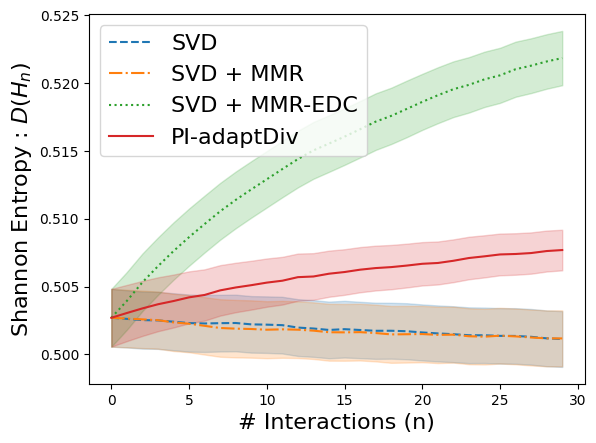

In [27]:
diversity_svd = diversity_all_users(active_users,'baseline')
diversity_mmr_exp = diversity_all_users(active_users,'mmr_exp_div_change',parameters = 'lambda_0.9')
diversity_mmr = diversity_all_users(active_users,'mmr',parameters = 'lambda_0.9')
diversity_PI = diversity_all_users(active_users,'adapt')

div_mmr_lambda = []
div_mmr_edc_lambda = []
for i in range(2,10):
   div_mmr_lambda.append(float(np.mean(get_final_diversity(active_users,'mmr', f'lambda_0.{i}'))))
   div_mmr_edc_lambda.append(float(np.mean(get_final_diversity(active_users,'mmr_exp_div_change', f'lambda_0.{i}'))))


##### Plot #####

line_width = 2

xlabel_fontsize = 16  # Font size for x-axis labels
title_fontsize = 16   # Font size for titles
legend_fontsize = 16 
default_colors = rcParams['axes.prop_cycle'].by_key()['color']



plot_with_confidence_interval(diversity_svd, color=default_colors[0], label = 'SVD',ls='--')
plot_with_confidence_interval(diversity_mmr, color = default_colors[1], label = 'SVD + MMR', ls='-.')
plot_with_confidence_interval(diversity_mmr_exp, color=default_colors[2], label = 'SVD + MMR-EDC', ls =':')
plot_with_confidence_interval(diversity_PI, color = default_colors[3], label = 'PI-adaptDiv')


plt.xlabel('# Interactions (n)', fontsize=xlabel_fontsize)
plt.ylabel('Shannon Entropy : $D(H_n)$', fontsize=xlabel_fontsize)
plt.legend(fontsize= xlabel_fontsize)

By quadrants

baseline : Done
mmr : Done
mmr_exp : Done
adapt : Done


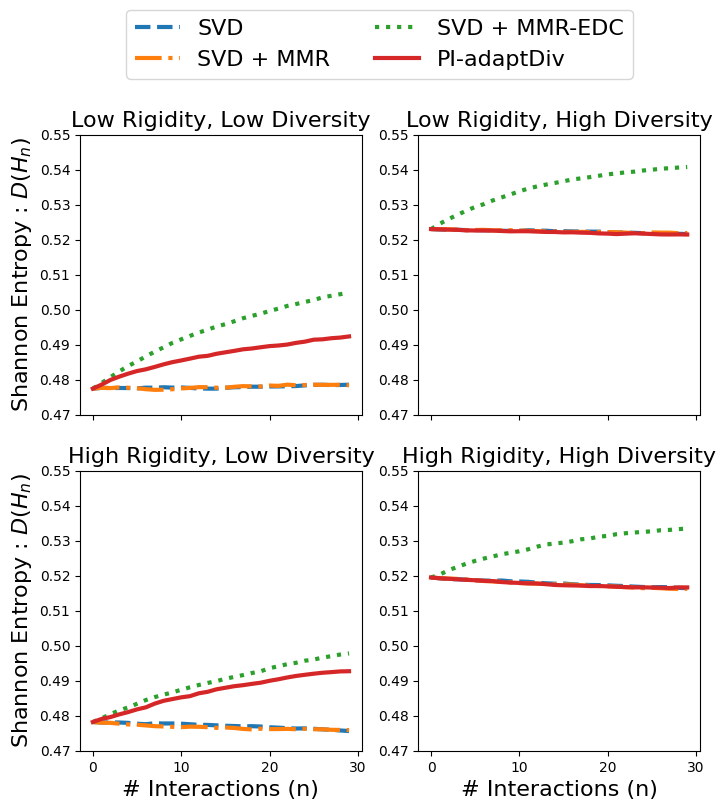

In [28]:
mean_diversity_baseline_Q1 = mean_diversity_all_users(Q1,'baseline')
mean_diversity_baseline_Q2 = mean_diversity_all_users(Q2,'baseline')
mean_diversity_baseline_Q3 = mean_diversity_all_users(Q3,'baseline')
mean_diversity_baseline_Q4 = mean_diversity_all_users(Q4,'baseline')
print("baseline : Done")

mean_diversity_mmr_Q1 = mean_diversity_all_users(Q1,'mmr',parameters = 'lambda_0.9')
mean_diversity_mmr_Q2 = mean_diversity_all_users(Q2,'mmr',parameters = 'lambda_0.9')
mean_diversity_mmr_Q3 = mean_diversity_all_users(Q3,'mmr',parameters = 'lambda_0.9')
mean_diversity_mmr_Q4 = mean_diversity_all_users(Q4,'mmr',parameters = 'lambda_0.9')
print("mmr : Done")

mean_diversity_mmr_exp_Q1 = mean_diversity_all_users(Q1,'mmr_exp_div_change',parameters = 'lambda_0.9')
mean_diversity_mmr_exp_Q2 = mean_diversity_all_users(Q2,'mmr_exp_div_change',parameters = 'lambda_0.9')
mean_diversity_mmr_exp_Q3 = mean_diversity_all_users(Q3,'mmr_exp_div_change',parameters = 'lambda_0.9')
mean_diversity_mmr_exp_Q4 = mean_diversity_all_users(Q4,'mmr_exp_div_change',parameters = 'lambda_0.9')
print("mmr_exp : Done")

mean_diversity_adapt_Q1 = mean_diversity_all_users(Q1,'adapt')
mean_diversity_adapt_Q2 = mean_diversity_all_users(Q2,'adapt')
mean_diversity_adapt_Q3 = mean_diversity_all_users(Q3,'adapt')
mean_diversity_adapt_Q4 = mean_diversity_all_users(Q4,'adapt')
print("adapt : Done")


line_width = 3

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=False)

axs[0, 0].plot(mean_diversity_baseline_Q1, label = 'SVD', linewidth = line_width,  ls ='--')
axs[0, 0].plot(mean_diversity_mmr_Q1, label = 'SVD + MMR',linewidth = line_width,ls = '-.')
axs[0, 0].plot(mean_diversity_mmr_exp_Q1, label = 'SVD + MMR-EDC',linewidth = line_width, ls = ':')
axs[0, 0].plot(mean_diversity_adapt_Q1, label ='PI-adaptDiv',linewidth = line_width)
axs[0, 0].set_ylabel('Shannon Entropy : $D(H_n$)', fontsize=xlabel_fontsize)
axs[0, 0].set_title('Low Rigidity, Low Diversity', fontsize=title_fontsize)
axs[0, 0].set_ylim([0.47, 0.55])

axs[0, 1].plot(mean_diversity_baseline_Q2,linewidth = line_width, ls ='--')
axs[0, 1].plot(mean_diversity_mmr_Q2,linewidth = line_width,ls = '-.')
axs[0, 1].plot(mean_diversity_mmr_exp_Q2,linewidth = line_width,ls = ':')
axs[0, 1].plot(mean_diversity_adapt_Q2,linewidth = line_width)
axs[0, 1].set_title('Low Rigidity, High Diversity', fontsize=title_fontsize)
axs[0, 1].set_ylim([0.47, 0.55])

axs[1, 0].plot(mean_diversity_baseline_Q3,linewidth = line_width, ls ='--')
axs[1, 0].plot(mean_diversity_mmr_Q3,linewidth = line_width,ls = '-.')
axs[1, 0].plot(mean_diversity_mmr_exp_Q3,linewidth = line_width,ls = ':')
axs[1, 0].plot(mean_diversity_adapt_Q3,linewidth = line_width)
axs[1, 0].set_xlabel('# Interactions (n)', fontsize=xlabel_fontsize)
axs[1, 0].set_ylabel('Shannon Entropy : $D(H_n)$', fontsize=xlabel_fontsize)
axs[1, 0].set_title('High Rigidity, Low Diversity', fontsize=title_fontsize)
axs[1, 0].set_ylim([0.47, 0.55])

axs[1, 1].plot(mean_diversity_baseline_Q4,linewidth = line_width, ls ='--')
axs[1, 1].plot(mean_diversity_mmr_Q4,linewidth = line_width,ls = '-.')
axs[1, 1].plot(mean_diversity_mmr_exp_Q4,linewidth = line_width, ls = ':')
axs[1, 1].plot(mean_diversity_adapt_Q4,linewidth = line_width)
axs[1, 1].set_xlabel('# Interactions (n)', fontsize=xlabel_fontsize)
axs[1, 1].set_title('High Rigidity, High Diversity', fontsize=title_fontsize)
axs[1, 1].set_ylim([0.47, 0.55])

fig.legend(loc='upper right', bbox_to_anchor=(0.83, 1.05),fontsize= legend_fontsize,ncol = 2)
fig.align_ylabels()

# 1.2. Recommended Diversity

In [29]:
recommendation_diversity_svd = recommendation_diversity_all_users(active_users,'baseline')
recommendation_diversity_mmr = recommendation_diversity_all_users(active_users,'mmr_exp_div_change',parameters = 'lambda_0.7')
recommendation_diversity_mmr_edc= recommendation_diversity_all_users(active_users,'mmr',parameters='lambda_0.9')
recommendation_diversity_PI_adaptDiv = recommendation_diversity_all_users(active_users,'adapt')

print(f"Average recommendation diversity SVD: {np.mean(recommendation_diversity_svd)}")
print(f"Average recommendation diversity SVD+MMR: {np.mean(recommendation_diversity_mmr)}")
print(f"Average recommendation diversity SVD+MMR-EDC: {np.mean(recommendation_diversity_mmr_edc)}")
print(f"Average recommendation diversity PI-adaptDiv: {np.mean(recommendation_diversity_PI_adaptDiv)}")

Average recommendation diversity SVD: 0.43423291496737493
Average recommendation diversity SVD+MMR: 0.5129886876914451
Average recommendation diversity SVD+MMR-EDC: 0.4437247912963579
Average recommendation diversity PI-adaptDiv: 0.491484865752629


# 2. Quality